In [2]:
# Get Noto font
!sudo apt-get update
!apt-get install fonts-noto-cjk 

获取:1 http://mirrors.aliyun.com/ubuntu jammy InRelease [270 kB]
获取:2 http://mirrors.aliyun.com/ubuntu jammy-security InRelease [129 kB]        
获取:3 http://mirrors.aliyun.com/ubuntu jammy-updates InRelease [128 kB]         
获取:4 http://mirrors.aliyun.com/ubuntu jammy-backports InRelease [127 kB]       
获取:5 http://mirrors.aliyun.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
获取:6 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
获取:7 https://developer.download.nvidia.cn/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,383 kB]
获取:8 http://mirrors.aliyun.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
获取:9 http://mirrors.aliyun.com/ubuntu jammy/main amd64 Packages [1,792 kB]
获取:10 http://mirrors.aliyun.com/ubuntu jammy/restricted amd64 Packages [164 kB]
获取:11 http://mirrors.aliyun.com/ubuntu jammy-security/universe amd64 Packages [1,243 kB]
获取:12 http://mirrors.aliyun.com/ubuntu jammy-security/main amd64 Packages [2,788 kB]
获取:13 http:

In [15]:
import base64
from openai import OpenAI
# Set OpenAI's API key and API base to use vLLM's API server.
openai_api_key = "EMPTY"
openai_api_base = "http://localhost:8000/v1"
client = OpenAI(
    api_key=openai_api_key,
    base_url=openai_api_base,
)
image_path = "/mnt/workspace/LLaMA-Factory/test_image/bettercallsaul.png"
with open(image_path, "rb") as f:
    encoded_image = base64.b64encode(f.read())
encoded_image_text = encoded_image.decode("utf-8")
base64_qwen = f"data:image;base64,{encoded_image_text}"
chat_response = client.chat.completions.create(
    model="Qwen2.5-VL-7B-Instruct",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": base64_qwen
                    },
                },
                {"type": "text", "text": "Who is the man in the image?"},
            ],
        },
    ],
)
# 提取所需的字段
simplified_response = {
    "id": chat_response.id,  # 提取 id
    "content": chat_response.choices[0].message.content,  # 提取生成的文本内容
    "model": chat_response.model  # 提取模型名称
}

# 打印简化后的响应
print("Simplified response:", simplified_response)

Simplified response: {'id': 'chatcmpl-56b8988291d145c7a9275c1eaf804d04', 'content': 'The man in the image is Bob Odenkirk, an American actor and comedian. He is best known for his role as Saul Goodman in the television series "Better Call Saul," which is a prequel to the popular show "Breaking Bad." In this image, he appears to be portraying his character Saul Goodman, sitting at a desk with a mug that reads "World\'s Greatest Lawyer."', 'model': 'Qwen2.5-VL-7B-Instruct'}


In [16]:
# Get Noto font
# !apt-get install fonts-noto-cjk 

import os
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from bs4 import BeautifulSoup, Tag
from pathlib import Path
import re

# Function to draw bounding boxes and text on images based on HTML content
def draw_bbox(image_path, resized_width, resized_height, full_predict):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    original_width = image.width
    original_height = image.height
    
    # Parse the provided HTML content
    soup = BeautifulSoup(full_predict, 'html.parser')
    # Extract all elements that have a 'data-bbox' attribute
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue  # Skip <ol> tags
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)  # Include <li> tags within <ol>
        else:
            filtered_elements.append(el)  # Include all other elements

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", 20)
    draw = ImageDraw.Draw(image)
    
    # Draw bounding boxes and text for each element
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)
        x1, y1, x2, y2 = map(int, bbox_str.split())
        
        # Calculate scaling factors
        scale_x = resized_width / original_width
        scale_y = resized_height / original_height
        
        # Scale coordinates accordingly
        x1_resized = int(x1 / scale_x)
        y1_resized = int(y1 / scale_y)
        x2_resized = int(x2 / scale_x)
        y2_resized = int(y2 / scale_y)
        
        if x1_resized > x2_resized:
            x1_resized, x2_resized = x2_resized, x1_resized
        if y1_resized > y2_resized:
            y1_resized, y2_resized = y2_resized, y1_resized
            
        # Draw bounding box
        draw.rectangle([x1_resized, y1_resized, x2_resized, y2_resized], outline='red', width=2)
        # Draw associated text
        draw.text((x1_resized, y2_resized), text, fill='black', font=font)

    # Display the image
    image.show()

# Function to clean and format HTML content
def clean_and_format_html(full_predict):
    soup = BeautifulSoup(full_predict, 'html.parser')
    
    # Regular expression pattern to match 'color' styles in style attributes
    color_pattern = re.compile(r'\bcolor:[^;]+;?')

    # Find all tags with style attributes and remove 'color' styles
    for tag in soup.find_all(style=True):
        original_style = tag.get('style', '')
        new_style = color_pattern.sub('', original_style)
        if not new_style.strip():
            del tag['style']
        else:
            new_style = new_style.rstrip(';')
            tag['style'] = new_style
            
    # Remove 'data-bbox' and 'data-polygon' attributes from all tags
    for attr in ["data-bbox", "data-polygon"]:
        for tag in soup.find_all(attrs={attr: True}):
            del tag[attr]

    classes_to_update = ['formula.machine_printed', 'formula.handwritten']
    # Update specific class names in div tags
    for tag in soup.find_all(class_=True):
        if isinstance(tag, Tag) and 'class' in tag.attrs:
            new_classes = [cls if cls not in classes_to_update else 'formula' for cls in tag.get('class', [])]
            tag['class'] = list(dict.fromkeys(new_classes))  # Deduplicate and update class names

    # Clear contents of divs with specific class names and rename their classes
    for div in soup.find_all('div', class_='image caption'):
        div.clear()
        div['class'] = ['image']

    classes_to_clean = ['music sheet', 'chemical formula', 'chart']
    # Clear contents and remove 'format' attributes of tags with specific class names
    for class_name in classes_to_clean:
        for tag in soup.find_all(class_=class_name):
            if isinstance(tag, Tag):
                tag.clear()
                if 'format' in tag.attrs:
                    del tag['format']

    # Manually build the output string
    output = []
    for child in soup.body.children:
        if isinstance(child, Tag):
            output.append(str(child))
            output.append('\n')  # Add newline after each top-level element
        elif isinstance(child, str) and not child.strip():
            continue  # Ignore whitespace text nodes
    complete_html = f"""```html\n<html><body>\n{" ".join(output)}</body></html>\n```"""
    return complete_html

In [17]:
from openai import OpenAI
import os
import base64
#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="Qwen2.5-VL-7B-Instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    llm_cfg = {
        'model': 'Qwen2.5-VL-7B-Instruct',  # 模型名称
        'model_server': 'http://localhost:8000/v1',  # 本地服务器地址
        'api_key': 'EMPTY',  # 本地服务器无需 API Key
        'generate_cfg': {
            'top_p': 0.8,       # 核心采样概率
            'max_tokens': 1024   # 生成的最大 token 数
        }
    }
    client = OpenAI(
        api_key=llm_cfg['api_key'],  # API Key
        base_url=llm_cfg['model_server']  # 本地服务器地址
        # #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        # api_key=os.getenv('DASHSCOPE_API_KEY'),
        # # api_key='EMPTY',
        # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

756 588
```html
<html><body>
<div class="image" data-bbox="10 12 436 178"><img data-bbox="10 12 435 178"/></div> 
 <p data-bbox="10 181 436 209">Table 7: Performance comparison of HLLM with SOTA models, SASRec*, means SASRec uses the ViT as an image encoder for item encoding and trained by BCE loss from (Cheng et al., 2024). * indicates the result is reproduced by us. $i$ indicates the number of negative samples and the batch size are increased from 512 and 128 to 28k and 512, respectively. “Scratch” indicates both Item LLM and User LLM are trained from scratch.</p> 
 <div class="image" data-bbox="10 212 436 279"><img data-bbox="10 212 435 279"/></div> 
 <p data-bbox="10 282 436 309">Table 8 show that while freezing the Item LLM leads to some metric decreases, performance still exceeds ID-based models, proving item caching is more effective. Given that user behaviors in industrial scenarios far exceed the numbers of items, HLLM’s training and serving costs can match those of ID-based m

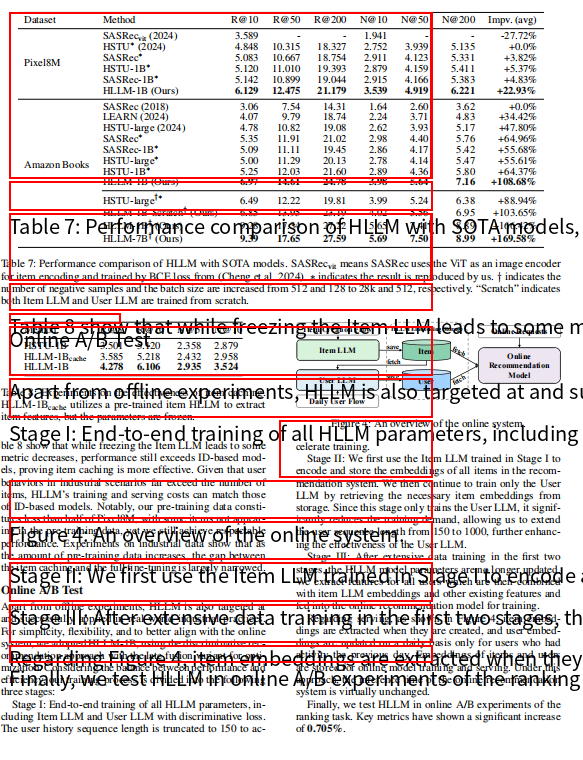

```html
<html><body>
<div class="image"><img/></div> 
 <p>Table 7: Performance comparison of HLLM with SOTA models, SASRec*, means SASRec uses the ViT as an image encoder for item encoding and trained by BCE loss from (Cheng et al., 2024). * indicates the result is reproduced by us. $i$ indicates the number of negative samples and the batch size are increased from 512 and 128 to 28k and 512, respectively. “Scratch” indicates both Item LLM and User LLM are trained from scratch.</p> 
 <div class="image"><img/></div> 
 <p>Table 8 show that while freezing the Item LLM leads to some metric decreases, performance still exceeds ID-based models, proving item caching is more effective. Given that user behaviors in industrial scenarios far exceed the numbers of items, HLLM’s training and serving costs can match those of ID-based models. Our pre-training data constitutes only half of Pixel8M, but we still achieve respectable performance. Experiments on industrial data show that as the amount of p

In [20]:
img_url = "/mnt/workspace/LLaMA-Factory/test_image/HLLM_with_graph_and_table.png"
image = Image.open(img_url)

system_prompt="You are an AI specialized in recognizing and extracting text from images. Your mission is to analyze the image document and generate the result in QwenVL Document Parser HTML format using specified tags while maintaining user privacy and data integrity."
prompt =  "QwenVL HTML "

## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)




## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'EMPTY'
min_pixels = 512*28*28
max_pixels = 2048*28*28
image = Image.open(img_url)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
output = inference_with_api(img_url, prompt, min_pixels=min_pixels, max_pixels=max_pixels)


# Visualization
print(input_height, input_width)
print(output)
draw_bbox(img_url, input_width, input_height, output)

ordinary_html = clean_and_format_html(output)
print(ordinary_html)

In [11]:
# generate ordinary html

# img_url = "assets/document_parsing/docparsing_example5.png"
prompt = "图片解析成html"
image = Image.open(img_url)

## Use a local HuggingFace model to inference.
# output, input_height, input_width = inference(img_url, prompt)
# print(output)

## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
from qwen_vl_utils import smart_resize
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
min_pixels = 512*28*28
max_pixels = 2048*28*28
image = Image.open(img_url)
width, height = image.size
input_height,input_width = smart_resize(height,width,min_pixels=min_pixels, max_pixels=max_pixels)
output = inference_with_api(img_url, prompt, min_pixels=min_pixels, max_pixels=max_pixels)
print(output)

```html
<html><body>
<h2>HLLM: Enhancing Sequential Recommendations via Hierarchical Large Language Models for Item and User Modeling</h2> 
 <p>Junyi Chen*, Lu Chi*, Bingyue Peng, Zehuan Yuan*</p> 
 <p>ByteDance</p> 
 <p>{chenjunyi.s, chilu, bingyue.peng, yuanzehuan} @bytedance.com</p> 
 <div class="abstract">
<p>Large Language Models (LLMs) have achieved remarkable success in various fields, prompting several studies to explore their potential in recommendation systems. However, these attempts have so far resulted in only modest improvements over traditional recommendation models. Moreover, three critical questions remain under-explored: firstly, the real value of LLMs' pre-trained weights, often considered to encapsulate world knowledge; secondly, the necessity of fine-tuning on recommendation tasks; thirdly, whether LLMs can exhibit the same scalability benefits in recommendation systems as they do in other domains. In this paper, we propose a novel Hierarchical Large Language Model

In [21]:
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor
from IPython.display import Markdown, display
from openai import OpenAI
import os
import base64


def plot_text_bounding_boxes(image_path, bounding_boxes, input_width, input_height):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        image_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = Image.open(image_path)
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Parsing out the markdown fencing
    bounding_boxes = parse_json(bounding_boxes)

    font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=10)

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(ast.literal_eval(bounding_boxes)):
      color = 'green'

      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # Draw the bounding box
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=1
      )

      # Draw the text
      if "text_content" in bounding_box:
        draw.text((abs_x1, abs_y2), bounding_box["text_content"], fill=color, font=font)

    # Display the image
    img.show()

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

# @title inference function
def inference(image_path, prompt, sys_prompt="You are a helpful assistant.", max_new_tokens=4096, return_input=False):
    image = Image.open(image_path)
    image_local_path = "file://" + image_path
    messages = [
        {"role": "system", "content": sys_prompt},
        {"role": "user", "content": [
                {"type": "text", "text": prompt},
                {"image": image_local_path},
            ]
        },
    ]
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print("text:", text)
    # image_inputs, video_inputs = process_vision_info([messages])
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt")
    inputs = inputs.to('cuda')

    output_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    if return_input:
        return output_text[0], inputs
    else:
        return output_text[0]
    



#  base 64 编码格式
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


# @title inference function with API
def inference_with_api(image_path, prompt, sys_prompt="You are a helpful assistant.", model_id="Qwen2.5-VL-7B-Instruct", min_pixels=512*28*28, max_pixels=2048*28*28):
    base64_image = encode_image(image_path)
    llm_cfg = {
        'model': 'Qwen2.5-VL-7B-Instruct',  # 模型名称
        'model_server': 'http://localhost:8000/v1',  # 本地服务器地址
        'api_key': 'EMPTY',  # 本地服务器无需 API Key
        'generate_cfg': {
            'top_p': 0.8,       # 核心采样概率
            'max_tokens': 1024   # 生成的最大 token 数
        }
    }
    client = OpenAI(
        api_key=llm_cfg['api_key'],  # API Key
        base_url=llm_cfg['model_server']  # 本地服务器地址
        # #If the environment variable is not configured, please replace the following line with the Dashscope API Key: api_key="sk-xxx".
        # api_key=os.getenv('DASHSCOPE_API_KEY'),
        # # api_key='EMPTY',
        # base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    )


    messages=[
        {
            "role": "system",
            "content": [{"type":"text","text": sys_prompt}]},
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "min_pixels": min_pixels,
                    "max_pixels": max_pixels,
                    # Pass in BASE64 image data. Note that the image format (i.e., image/{format}) must match the Content Type in the list of supported images. "f" is the method for string formatting.
                    # PNG image:  f"data:image/png;base64,{base64_image}"
                    # JPEG image: f"data:image/jpeg;base64,{base64_image}"
                    # WEBP image: f"data:image/webp;base64,{base64_image}"
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]
    completion = client.chat.completions.create(
        model = model_id,
        messages = messages,
       
    )
    return completion.choices[0].message.content

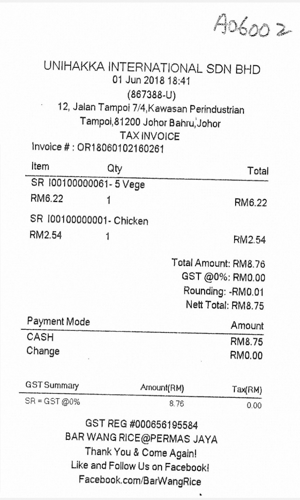

Here is the extracted key-value information from the image:

- **Company**: UNIHAKKA INTERNATIONAL SDN BHD
- **Date**: 01 Jun 2018
- **Address**: 12, Jalan Tampoi 7/4,Kawasan Perindustrian Tampoi,81200 Johor Bahru,Johor
- **Item Name**:
  - SR I00100000061-5 Vege
  - SR I00100000001-Chicken
- **Invoice Number**: OR18060102160261
- **Total**: RM8.75
- **Last Line**: GST REG #000656195584 BAR WANG RICE@PERMAS JAYA Thank You & Come Again! Like and Follow Us on Facebook! Facebook.com/BarWangRice

In [28]:
image_path = "/mnt/workspace/LLaMA-Factory/test_image/ocr_example3.jpg"
prompt = "Extract the key-value information in the format:{\"company\": \"\",\"date\": \"\", \"address\": \"\", \"item_name\": \"\",\"invoice_number\": \"\",\"total\": \"\",\"Last_line\": \"\"}"

image = Image.open(image_path)
display(image.resize((300,500)))

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# display(Markdown(response))


## Use an API-based approach to inference. Apply API key here: https://bailian.console.alibabacloud.com/?apiKey=1
response = inference_with_api(image_path, prompt)
display(Markdown(response))

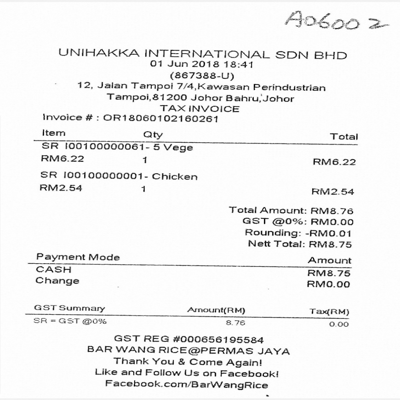

```json
{
    "Company": "UNIHAKKA INTERNATIONAL SDN BHD",
    "date": "01 Jun 2018 18:41",
    "address": "12, Jalan Tampoi 7/4,Kawasan Perindustrian Tampoi,81200 Johor Bahru,Johor",
    "invoice_number": "OR18060102160261",
    "item_number_with_price": [
        {
            "Item Number": "SR I00100000061- 5 Vege",
            "Price": "RM6.22"
        },
        {
            "Item Number": "SR I00100000001- Chicken",
            "Price": "RM2.54"
        }
    ],
    "Total Amount": "RM8.75",
    "Payment mode": "CASH",
    "website_link": "Facebook.com/BarWangRice"
}
```

In [29]:
image_path = "/mnt/workspace/LLaMA-Factory/test_image/ocr_example3.jpg"
prompt = "提取图中的：['Company','date','address','invoice_number','item_number_with_price','Total Amount','Payment mode','website_link']，out put in Json type。"

image = Image.open(image_path)
display(image.resize((400,400)))

## Use a local HuggingFace model to inference.
# response = inference(image_path, prompt)
# display(Markdown(response))


## Use an API-based approach to inference.
# os.environ['DASHSCOPE_API_KEY'] = 'your_api_key_here'
response = inference_with_api(image_path, prompt)
display(Markdown(response))